# GAN

#### Load Dependencies 

In [2]:
import numpy as np
import os

import keras
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Conv2D, BatchNormalization, Dropout, Flatten
from keras.layers import Activation, Reshape, Conv2DTranspose, UpSampling2D
from keras.optimizers import RMSprop

import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

#### Load data

In [3]:
input_images = "apple.npy"

In [4]:
data = np.load(input_images)

In [5]:
data.shape

(144722, 784)

In [23]:
data[4343]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,  46,  69,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0, 163, 209,   0,   0,  46, 122, 171,  84,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0, 170, 207,  42, 171, 254, 255, 249,
        88,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0, 174, 232, 253, 255, 255,
       215,  50,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 178, 233, 255,
       255, 151,  10,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

In [24]:
data = data/255
data = np.reshape(data, (data.shape[0], 28, 28, 1))
img_w, img_h = data.shape[1:3]
data.shape

(144722, 28, 28, 1)

In [25]:
data[4343]

array([[[0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.18039216],
        [0.27058824],
        [0.        ],
        [0.        ],
        

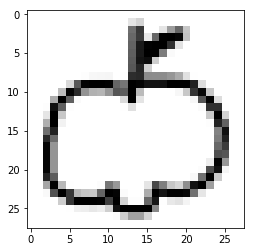

In [26]:
plt.imshow(data[4343,:,:,0], cmap='Greys')

#### Create Discriminator network

In [27]:
def discriminator_builder(width=64, p=0.4):
    
    # define inputs:
    inputs = Input((img_w, img_h, 1))
    
    # convolutional layers:
    conv1 = Conv2D(width*1, 5, strides=2, padding='same', activation='relu')(inputs)
    conv1 = Dropout(p)(conv1)
    
    conv2 = Conv2D(width*2, 5, strides=2, padding='same', activation='relu')(conv1)
    conv2 = Dropout(p)(conv2)
    
    conv3 = Conv2D(width*4, 5, strides=2, padding='same', activation='relu')(conv2)
    conv3 = Dropout(p)(conv3)
    
    conv4 = Conv2D(width*8, 5, strides=1, padding='same', activation='relu')(conv3)
    conv4 = Flatten()(Dropout(p)(conv4))
    
    # output layer:
    output = Dense(1, activation='sigmoid')(conv4)
    
    # model definition:
    model = Model(inputs=inputs, outputs=output)
    model.summary()
    
    return model

In [28]:
discriminator = discriminator_builder()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 256)         819456    
_________________________________________________________________
dropout_3 (Dropout)          (None, 4, 4, 256)         0         
__________

In [29]:
discriminator.compile(loss='binary_crossentropy', optimizer=RMSprop(lr=0.0008, decay=6e-8, clipvalue=1.0), metrics=['accuracy'])

#### Create Generator network

In [34]:
def generator_builder(z_dim=100, width=64, p=0.4):
    
    # define inputs:
    inputs = Input((z_dim,))
    
    # first dense layer:
    dense1 = Dense(7*7*64)(inputs)
    dense1 = BatchNormalization(momentum=0.9)(dense1)
    dense1 = Activation(activation='relu')(dense1)
    dense1 = Reshape((7,7,64))(dense1)
    dense1 = Dropout(p)(dense1)
    
    # deconvolutional layers:
    conv1 = UpSampling2D()(dense1)
    conv1 = Conv2DTranspose(int(width/2), kernel_size=5, padding='same', activation=None)(conv1)
    conv1 = BatchNormalization(momentum=0.9)(conv1)
    conv1 = Activation(activation='relu')(conv1)
    
    conv2 = UpSampling2D()(conv1)
    conv2 = Conv2DTranspose(int(width/4), kernel_size=5, padding='same', activation=None)(conv2)
    conv2 = BatchNormalization(momentum=0.9)(conv2)
    conv2 = Activation(activation='relu')(conv2)
    
    conv3 = Conv2DTranspose(int(width/8), kernel_size=5, padding='same', activation=None)(conv1)
    conv3 = BatchNormalization(momentum=0.9)(conv3)
    conv3 = Activation(activation='relu')(conv3)
    
    # output layer:
    output = Conv2D(1, kernel_size=5, padding='same', activation='sigmoid')(conv3)
    
    # model definition:
    model = Model(inputs=inputs, outputs=output)
    model.summary()
    
    return model

In [35]:
generator = generator_builder()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 3136)              316736    
_________________________________________________________________
batch_normalization_2 (Batch (None, 3136)              12544     
_________________________________________________________________
activation_2 (Activation)    (None, 3136)              0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 14, 14, 64)        0         
__________